# Adversarial attacks playground

NNDL Project Fall 2022
2022-11-30

## 0. Notebook Setup

Imports

In [10]:
import os

import torch
import torchvision
from torchvision import models as models

from src.explainability.GradCam import GradCam
from src.utils.ImageDisplayerGradCam import ImageDisplayerGradCam
from src.data.ImageNet300 import ImageNet300Dataset
from src.utils.getimagenetclasses import get_classes

In [11]:
torch.__version__

'1.10.0'

global params

In [12]:
DATA_FOLDER = os.path.join(os.path.abspath(""),"src/data/")
USE_CUDA = False

print(DATA_FOLDER)

/home/wh2529/dlnn-project/src/data/


## 1. Params

### MNIST & GoogLeNet

#### MNIST dataset

In [13]:
dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, 
    train=False,download=True, transform=torchvision.transforms.ToTensor())

#### GoogLeNet Model

In [14]:
torchvision.models.list_models()

AttributeError: module 'torchvision.models' has no attribute 'list_models'

In [81]:
#model = models.GoogLeNet(models.GoogLeNet_Weights.IMAGENET1K_V1)
#model = models.GoogLeNet(weights="IMAGENET1K_V1")
#model = models.googlenet.GoogLeNet(weights=models.googlenet.GoogLeNet_Weights.DEFAULT)

### A)
model = models.googlenet(pretrained = True)#weights=models.GoogLeNet_Weights.DEFAULT, transform_input=False)
### B)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

In [18]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (USE_CUDA and torch.cuda.is_available()) else "cpu")
# Initialize the network
model.to(device)
model.eval()

CUDA Available:  True


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## 2. Attack

### 2.1 Fast gradient sign method

In [37]:
# if smaller subset desired
indices = torch.randperm(len(dataset))[:100]
data_loader = torch.utils.data.DataLoader(dataset,batch_size=100,#shuffle=True,
    sampler=torch.utils.data.SubsetRandomSampler(indices))

In [9]:
def fgsm_perturbate(image, epsilon, data_grad):
    sign = data_grad.sign() # sign of gradient
    perturbed_image = image + epsilon * sign
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [38]:
# requires batch_size=1
epsilon = 0.00

correct, incorrect = 0,0
# adapt model to have output 10 (image classes)
# need to train again !!!
model.fc = torch.nn.Linear(model.fc.in_features, 10) # !!! CAN WE DO THIS?
    
for img, target in data_loader:
    # adapt input to be nx3xhxw
    if img.size()[1] == 1:
        img = img.expand((img.size()[0], 3, img.size()[2], img.size()[3]))
    
    img, target = img.to(device), target.to(device)
    img.requires_grad = True
    #print(img.size())
    output = model(img) # probabilities
    #print("output:", output.size(), output)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    print("init_pred", init_pred.size())

    # skip images that were wrongly classified in the first place
    if init_pred.item() != target.item():
        print(init_pred.item(), target.item())
        continue
    else:
        print("else")
        print(init_pred.item(), target.item())
        # Calculate the loss
        loss = torch.nn.functional.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # produce FGSM Attack
        grad_wrt_data = img.grad.data
        perturbed_img = fgsm_perturbate(img, epsilon, grad_wrt_data)

        # Re-classify the perturbed image
        print("perturbed input", perturbed_img.shape)
        output = model(perturbed_img)
        print("OUTPUT ", output)
        pred = output.max(1, keepdim=True)[1]
        print("PREDICTION 1", pred)

        if pred.item() == target.item():
            correct += 1
        else:
            incorrect += 1
length = correct+incorrect
print(correct, "correct")
print(incorrect, "incorrect")
length = float(length)
print(length)
accuracy = correct / length
print(f"accuracy: {accuracy}, \t correct: {correct} ({correct/length}) \t incorrect: {incorrect} ({incorrect/length})")

init_pred torch.Size([100, 1])


ValueError: only one element tensors can be converted to Python scalars

### 2.2 UNIVERSAL PERTURBATIONS

In [76]:
# if smaller subset desired
indices = torch.randperm(len(dataset))[:100]
data_loader = torch.utils.data.DataLoader(dataset,batch_size=50,#shuffle=True,
    sampler=torch.utils.data.SubsetRandomSampler(indices))

In [20]:
%load_ext autoreload
%autoreload 2
from src.attacks.attacks import UniversalPerturbation

In [86]:

model.fc = torch.nn.Linear(model.fc.in_features, 10) # !!! CAN WE DO THIS?
    
for inputs, targets in data_loader:
    #print(inputs.size(), targets.size())
    if inputs.size()[-3] == 1:
        inputs = inputs.expand((inputs.size()[0], 3, inputs.size()[2], inputs.size()[3]))
    #print(inputs.size(), targets.size())
inputs, targets = inputs.to(device), targets.to(device)
up = UniversalPerturbation(model, torch.nn.functional.nll_loss).compute_perturbation(inputs, targets)

inputs torch.Size([50, 3, 28, 28])
predictions:  torch.Size([50]) 

targets torch.Size([50]) 

fool_rate 0.88
0
predictions:  torch.Size([50]) 

targets torch.Size([50]) 

fool_rate 0.96


In [88]:
up.size()

torch.Size([1, 3, 28, 28])

## 3. Explanation

In [19]:
from src.explainability.GradCam import GradCam
from src.utils.get_mnist_classes import get_classes
from torchvision import transforms
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np

In [82]:
for name, module in list(model.named_modules())[-10:]:
    #if isinstance(module, torch.nn.Conv2d):
    print(name, module)

model.conv2d

inception5b.branch3.1.conv Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
inception5b.branch3.1.bn BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
inception5b.branch4 Sequential(
  (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=True)
  (1): BasicConv2d(
    (conv): Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
)
inception5b.branch4.0 MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=True)
inception5b.branch4.1 BasicConv2d(
  (conv): Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
inception5b.branch4.1.conv Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
inception5b.branch4.1.bn BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_s

AttributeError: 'GoogLeNet' object has no attribute 'conv2d'

In [5]:
print(list(model.modules())[-5])

NameError: name 'model' is not defined

In [26]:
indices = torch.randperm(len(dataset))[:100]
data_loader = torch.utils.data.DataLoader(dataset,batch_size=1,#shuffle=True,
    sampler=torch.utils.data.SubsetRandomSampler(indices))

In [39]:
for i in data_loader:
    break

In [86]:
target_

Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [87]:
target_layer = list(model.modules())[-5]
cam = GradCam(model, target_layer, 10, multi_label = False)
classes = get_classes()
print(classes)


{0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}


In [88]:
image_dispalyer = ImageDisplayerGradCam(model, 
    cam, 
    classes,
    reshape = transforms.Resize((28,28)), 
    multi_label = False, 
    image_dir = 'src/data/MNIST/raw/',
    pdf = False)

In [32]:
#fig, ax = plt.subplots(1, 1,)
for img, label in data_loader:
    #if img.size()[1] == 1:
    #    img = img.expand((img.size()[0], 3, img.size()[2], img.size()[3]))
    
    #print(len(img))
    #print(img.size(), img.T.size())
    #print(label)
    #print(img)
    #img_255 = (img[0,0].numpy()*255).astype(np.uint8) # convert from 0-1 floats to 0-255 ints
    #print(img_255)
    #point = {"image" : img, "label": label, "filename": None}
    ###image = (PIL.Image.fromarray(img_255))
    ###ax.imshow(image)
    hm = image_dispalyer.display_images(img, display_labels_or_predictions = False, return_heatmap=True)
    print(hm)
    #image_dispalyer.display_images(point, display_labels_or_predictions = True)
    break

IndexError: too many indices for tensor of dimension 4

In [69]:
import os
import numpy as np
import PIL.Image

import torch
from torchvision import transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt


class ImageDisplayerGradCam():

    def __init__(self, model, grad_cam, classes, reshape = transforms.Resize((256,256)), multi_label = True, image_dir = '', pdf = False, save_figs = False):


        self.model = model
        self.grad_cam = grad_cam

        self.multi_label = multi_label

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.classes = classes

        self.image_dir = image_dir

        self.pdf = pdf
        
        # True = Display labels, False = Display Predictions
        self.display_labels_or_predictions = True
    
        self.save_figs = save_figs


        # Reshape image, as 
        self.reshape = reshape


    def display_images(self, data, target_class = None, display_labels_or_predictions = True):

        self._display_images(data, target_class, display_labels_or_predictions)


    def _display_images(self, data, target_class , display_labels_or_predictions):
        
        self.display_labels_or_predictions = display_labels_or_predictions

        self.model.eval()

        image = data['image'].to(self.device)
        if len(image.shape) == 3:
            image = image.unsqueeze(0)
        labels = data['label']
        image_file_name = data['filename']

        output = self.model(image)

        if self.multi_label:
            output = torch.sigmoid(output)
            output = output > 0.5
        else:
            output = torch.argmax(output, axis = 1)

        # Retreive predictions, to know what the model predicted
        if target_class is not None:
            self._display_target_class(image, output, labels, target_class, image_file_name)
        elif self.multi_label:
            self._display_multi_label(image, output, labels, image_file_name)
        else:
            self._display_single_label(image, output, labels, image_file_name)

    def _display_multi_label(self, image, prediction, labels, image_file_name):
        """
        Generate sailency maps for each of the 
        """
        if prediction.nonzero().nelement() == 0:
            predictions_str_list = ["None"]
        else:
            pred_ind = prediction.squeeze(0).cpu().numpy()
            predictions_str_list = [f"{self.classes[ind]} ({ind})" for ind, pred in enumerate(pred_ind) if pred == 1]

        true_classes_str_list = [f"{self.classes[ind]} ({ind})" for ind, lab in enumerate(labels) if lab == 1]

        print("True classes:", ', '.join(true_classes_str_list))
        print("Predictions:",  ', '.join(predictions_str_list))

        if self.display_labels_or_predictions:
            classes_to_iterate = [ind for ind, lab in enumerate(labels) if lab == 1]
            print("Displaying true labels")
            target_classes_str_list = true_classes_str_list
        else:
            classes_to_iterate = [ind for ind, pred in enumerate(pred_ind) if pred == 1]
            print("Displaying predictions")
            target_classes_str_list = predictions_str_list

        for target_nr, target in enumerate(classes_to_iterate):

            heatmap, _ = self.grad_cam(image, target)

            target_class_str = target_classes_str_list[target_nr]

            self._show_image_with_heapmap(heatmap, target, true_classes_str_list, target_class_str, image_file_name)


    def _display_single_label(self, image, prediction, label, image_file_name):

        prediction = prediction.item()
        try:
            label = label.item()
        except:
            pass
        
        print("True class:", self.classes[label], f"{label}")
        print("Predictions:",  self.classes[prediction], f"{prediction}")

        if self.display_labels_or_predictions:
            target_class = label
            print("Displaying true labels")
        else:
            target_class = prediction
            print("Displaying predictions")

        heatmap, _ = self.grad_cam(image, target_class)

        true_class_str = [f"{self.classes[label]} ({label})"]
        target_class_str = f"{self.classes[target_class]} ({target_class})"

        self._show_image_with_heapmap(heatmap, target_class, true_class_str, target_class_str, image_file_name)


    def _display_target_class(self, image, prediction, labels, target_class, image_file_name):
        
        if self.multi_label:
            true_classes_str_list = [f"{self.classes[ind]} ({ind})" for ind, lab in enumerate(labels) if lab == 1]
            print('True classes:', '\n'.join(true_classes_str_list))
        else:
            try:
                true_cls = labels[0].item()
            except Exception:
                true_cls = labels
            true_classes_str_list = [f"{self.classes[true_cls]} ({true_cls})"]
            print("True Class:", true_cls)
        
        target_class_str =  f"{self.classes[target_class]} ({target_class})"
        print("Target Class:", target_class_str)

        heatmap, _ = self.grad_cam(image, target_class)
    
        self._show_image_with_heapmap(heatmap, target_class, true_classes_str_list, target_class_str, image_file_name)
        

    def _show_image_with_heapmap(self, heatmap, target_class, true_classes_str_list, target_class_str, image_file_name):
        fig, ax = plt.subplots(1, 1,)

        if isinstance(image_file_name, list):
            image_file_name = image_file_name[0]

        image = self.reshape((PIL.Image.open(image_file_name)))

        ax.axis('off')
        ax.imshow(image)
        
        true_classes  = ', '.join(true_classes_str_list)
        ax.set_title(f'True class(es): {true_classes}. \nTarget class: {target_class_str}')

        cmap = plt.get_cmap('jet')
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, 0.8, 255+4)
        w, h = image.size
        y, x = np.mgrid[0:h, 0:w]
        cb = ax.contourf(x, y, heatmap, 15, cmap=cmap)
        plt.colorbar(cb)
        
        if os.name == 'nt':
            file_name = image_file_name.split('.')[0].split('\\')[-1]
        else:
            file_name = image_file_name.split('.')[0].split('/')[-1]

        if self.pdf:
            print(f'{self.image_dir}/pdf/{file_name}_heatmap_{target_class}.pdf')
            if self.save_figs:
                plt.savefig(f'{self.image_dir}/{file_name}_heatmap_{target_class}.pdf')
        else:
            print(f'{self.image_dir}/{file_name}_heatmap_{target_class}.png')
            if self.save_figs:
                plt.savefig(f'{self.image_dir}/{file_name}_heatmap_{target_class}.png')
        plt.show()

In [70]:
target_layer = model.conv2

In [102]:
cam = GradCam(model, target_layer, 10, multi_label = False)
image_dispalyer = ImageDisplayer(model, 
    cam, 
    classes, 
    multi_label = False, 
    mnist = True,
    image_dir = 'mnist_examples', pdf = True)

In [72]:
import torch.nn as nn
import torch.nn.functional as F

In [73]:
class SimpleCNN(nn.Module):
    def __init__(self, multi_label=False):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        if multi_label:
            self.fc1 = nn.Linear(28*28*64, 128)
        else:
            self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, 2)
        out = self.dropout1(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        return out


In [74]:
model = SimpleCNN()

In [76]:
trainer 

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

True class: seven 7
Predictions: zero 0
Displaying true labels
Focus class: 7
mnist_examples/pdf/mnist_image_heatmap_7.pdf


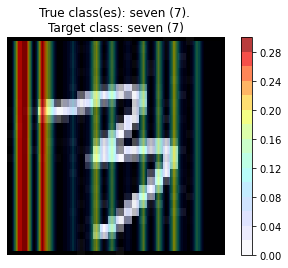

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: two 2
Predictions: zero 0
Displaying true labels
Focus class: 2
mnist_examples/pdf/mnist_image_heatmap_2.pdf


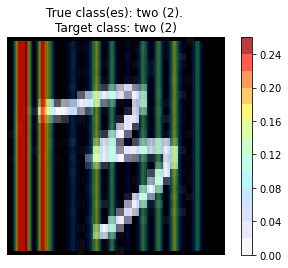

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: one 1
Predictions: zero 0
Displaying true labels
Focus class: 1
mnist_examples/pdf/mnist_image_heatmap_1.pdf


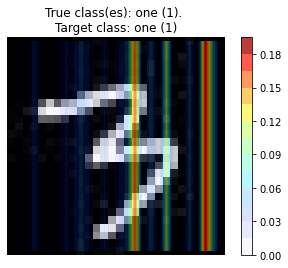

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: zero 0
Predictions: zero 0
Displaying true labels
Focus class: 0
mnist_examples/pdf/mnist_image_heatmap_0.pdf


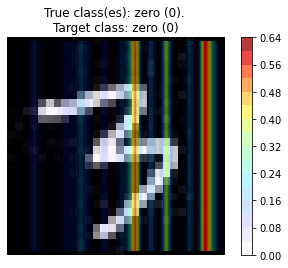

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: four 4
Predictions: zero 0
Displaying true labels
Focus class: 4
mnist_examples/pdf/mnist_image_heatmap_4.pdf


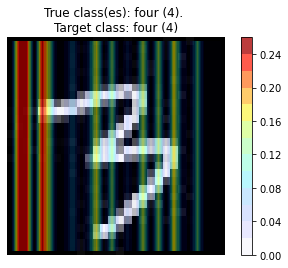

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: one 1
Predictions: zero 0
Displaying true labels
Focus class: 1
mnist_examples/pdf/mnist_image_heatmap_1.pdf


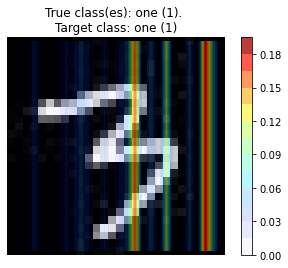

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: four 4
Predictions: zero 0
Displaying true labels
Focus class: 4
mnist_examples/pdf/mnist_image_heatmap_4.pdf


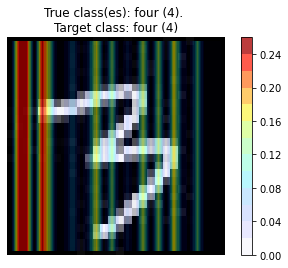

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: nine 9
Predictions: zero 0
Displaying true labels
Focus class: 9
mnist_examples/pdf/mnist_image_heatmap_9.pdf


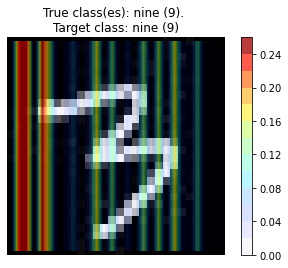

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: five 5
Predictions: zero 0
Displaying true labels
Focus class: 5
mnist_examples/pdf/mnist_image_heatmap_5.pdf


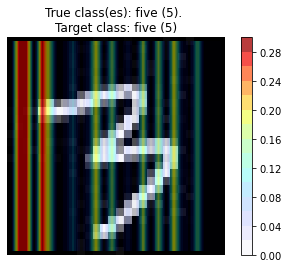

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: nine 9
Predictions: zero 0
Displaying true labels
Focus class: 9
mnist_examples/pdf/mnist_image_heatmap_9.pdf


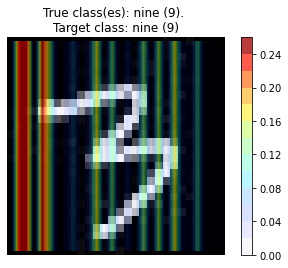

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: zero 0
Predictions: zero 0
Displaying true labels
Focus class: 0
mnist_examples/pdf/mnist_image_heatmap_0.pdf


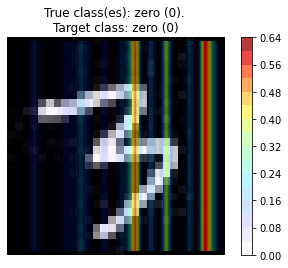

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: six 6
Predictions: zero 0
Displaying true labels
Focus class: 6
mnist_examples/pdf/mnist_image_heatmap_6.pdf


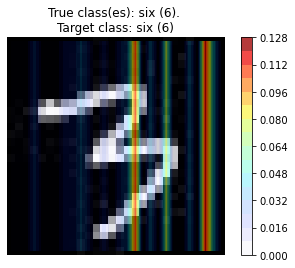

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: nine 9
Predictions: zero 0
Displaying true labels
Focus class: 9
mnist_examples/pdf/mnist_image_heatmap_9.pdf


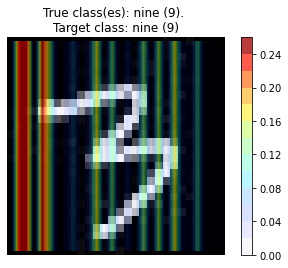

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: zero 0
Predictions: zero 0
Displaying true labels
Focus class: 0
mnist_examples/pdf/mnist_image_heatmap_0.pdf


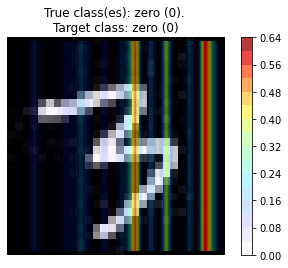

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: one 1
Predictions: zero 0
Displaying true labels
Focus class: 1
mnist_examples/pdf/mnist_image_heatmap_1.pdf


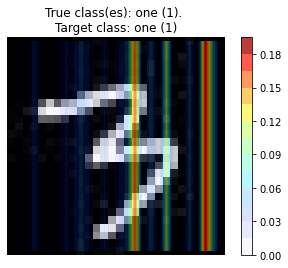

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: five 5
Predictions: zero 0
Displaying true labels
Focus class: 5
mnist_examples/pdf/mnist_image_heatmap_5.pdf


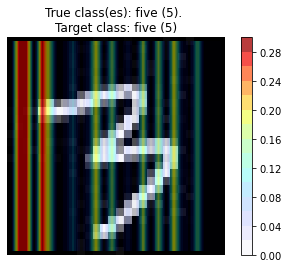

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: nine 9
Predictions: zero 0
Displaying true labels
Focus class: 9
mnist_examples/pdf/mnist_image_heatmap_9.pdf


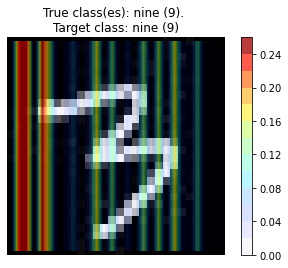

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: seven 7
Predictions: zero 0
Displaying true labels
Focus class: 7
mnist_examples/pdf/mnist_image_heatmap_7.pdf


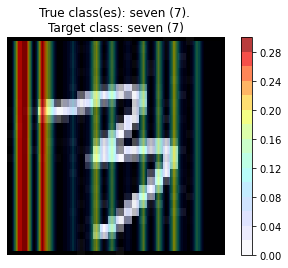

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: three 3
Predictions: zero 0
Displaying true labels
Focus class: 3
mnist_examples/pdf/mnist_image_heatmap_3.pdf


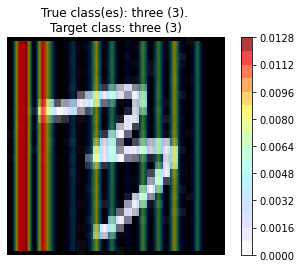

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: four 4
Predictions: zero 0
Displaying true labels
Focus class: 4
mnist_examples/pdf/mnist_image_heatmap_4.pdf


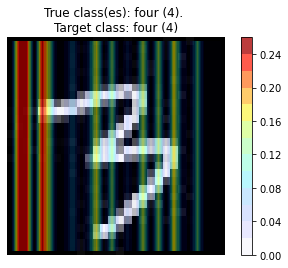

In [103]:
for i in range(0,20):
        img_1 = data_loader.dataset[i]
        img_1 = {'image':img.expand((img.size()[0], 3, img.size()[2], img.size()[3])), 'label':img_1[1], 'filename':None}
        
        image_dispalyer.display_images(img_1, display_labels_or_predictions = True)

In [101]:
model.fc = nn.Linear(1024,10)